<h3>8.1 用变分自编码器生成图像</h3>

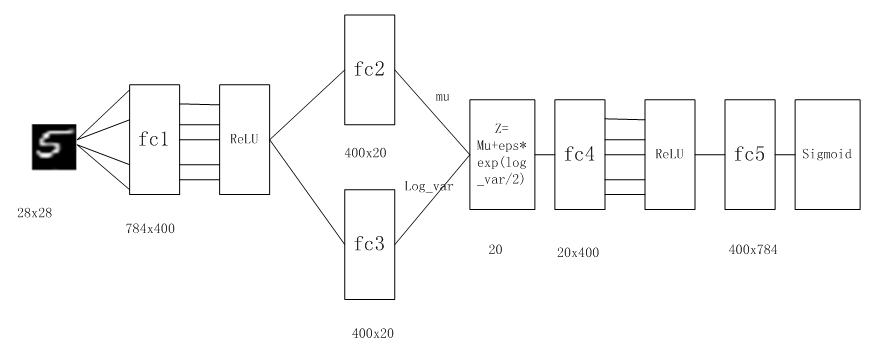

In [338]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image


# 设备配置
torch.cuda.set_device(1) # 这句用来设置pytorch在哪块GPU上运行，这里假设使用序号为1的这块GPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#在当前目录，创建不存在的目录ave_samples
sample_dir = 'ave_samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# 定义一些超参数
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 30
batch_size = 128
learning_rate = 0.001

# 下载MNIST训练集，这里因已下载，故download=False
dataset = torchvision.datasets.MNIST(root='data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=False)

#数据加载
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)


# 定义AVE模型
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#开始训练模型
for epoch in range(num_epochs):
    model.train()
    for i, (x, _) in enumerate(data_loader):
        # 前向传播
        model.zero_grad()
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        #反向传播及优化器
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    
    with torch.no_grad():
        # 保存采样图像，即潜在向量Z通过解码器生成的新图像
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # 保存重构图像，即原图像通过解码器生成的图像
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

Epoch[1/30], Step [100/469], Reconst Loss: 20423.5039, KL Div: 1497.4268
Epoch[1/30], Step [200/469], Reconst Loss: 18074.3887, KL Div: 1960.4033
Epoch[1/30], Step [300/469], Reconst Loss: 15487.4551, KL Div: 2352.7061
Epoch[1/30], Step [400/469], Reconst Loss: 14114.9980, KL Div: 2509.6038
Epoch[2/30], Step [100/469], Reconst Loss: 13554.3174, KL Div: 2863.8770
Epoch[2/30], Step [200/469], Reconst Loss: 12843.1699, KL Div: 2929.6050
Epoch[2/30], Step [300/469], Reconst Loss: 12467.1152, KL Div: 2939.1704
Epoch[2/30], Step [400/469], Reconst Loss: 12599.7930, KL Div: 3030.2324
Epoch[3/30], Step [100/469], Reconst Loss: 11509.2432, KL Div: 3049.3989
Epoch[3/30], Step [200/469], Reconst Loss: 11484.9121, KL Div: 2964.4810
Epoch[3/30], Step [300/469], Reconst Loss: 11593.9053, KL Div: 3034.6235
Epoch[3/30], Step [400/469], Reconst Loss: 11742.9102, KL Div: 3038.9167
Epoch[4/30], Step [100/469], Reconst Loss: 11212.3379, KL Div: 3059.9778
Epoch[4/30], Step [200/469], Reconst Loss: 10784.51

Epoch[29/30], Step [100/469], Reconst Loss: 9692.6348, KL Div: 3300.3608
Epoch[29/30], Step [200/469], Reconst Loss: 9893.6953, KL Div: 3273.6987
Epoch[29/30], Step [300/469], Reconst Loss: 9521.3486, KL Div: 3259.1191
Epoch[29/30], Step [400/469], Reconst Loss: 9853.0811, KL Div: 3377.7917
Epoch[30/30], Step [100/469], Reconst Loss: 10063.2480, KL Div: 3291.5625
Epoch[30/30], Step [200/469], Reconst Loss: 9703.7441, KL Div: 3332.4224
Epoch[30/30], Step [300/469], Reconst Loss: 9818.6143, KL Div: 3306.7666
Epoch[30/30], Step [400/469], Reconst Loss: 9612.6357, KL Div: 3308.6094


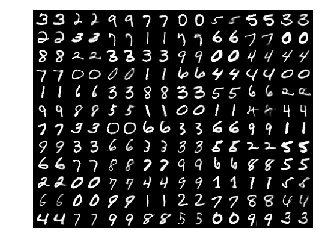

In [339]:
reconsPath = './ave_samples/reconst-30.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

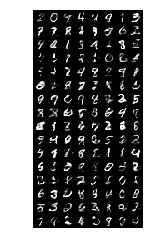

In [340]:
genPath = './ave_samples/sampled-30.png'
Image = mpimg.imread(genPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

<h3>8.3用GAN生成图像</h3>

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image


# 设备配置
torch.cuda.set_device(1) # 这句用来设置pytorch在哪块GPU上运行，这里假设使用序号为1的这块GPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 定义一些超参数
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'gan_samples'

# 在当前目录，创建不存在的目录gan_samples
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Image processing
trans = transforms.Compose([
                transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])


# MNIST dataset
mnist = torchvision.datasets.MNIST(root='data3',
                                   train=True,
                                   transform=trans,
                                   download=False)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)



In [2]:
# 构建判断器
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# 构建生成器，这个相当于AVE中的解码器 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

# 把判别器和生成器迁移到GPU上
D = D.to(device)
G = G.to(device)

# 定义判别器的损失函数交叉熵及优化器
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

#Clamp函数x限制在区间[min, max]内
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# 开始训练
total_step = len(data_loader)


In [5]:
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # 定义图像是真或假的标签
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      训练判别器                                    #
        # ================================================================== #

        # 定义判断器对真图片的损失函数
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 定义判别器对假图片（即由潜在空间点生成的图片）的损失函数
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs        
     
        # 得到判别器总的损失函数
        d_loss = d_loss_real + d_loss_fake
        
        # 对生成器、判别器的梯度清零        
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        训练生成器                                  #
        # ================================================================== #

        # 定义生成器对假图片的损失函数，这里我们要求
        #判别器生成的图片越来越像真图片，故损失函数中
        #的标签改为真图片的标签，即希望生成的假图片，
        #越来越靠近真图片
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        
        g_loss = criterion(outputs, real_labels)
        
        # 对生成器、判别器的梯度清零
        #进行反向传播及运行生成器的优化器
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    # 保存真图片
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # 保存假图片
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# 保存模型
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Epoch [0/200], Step [200/600], d_loss: 0.0528, g_loss: 4.0099, D(x): 0.99, D(G(z)): 0.04
Epoch [0/200], Step [400/600], d_loss: 0.0588, g_loss: 5.5718, D(x): 0.99, D(G(z)): 0.04
Epoch [0/200], Step [600/600], d_loss: 0.0730, g_loss: 4.4847, D(x): 0.98, D(G(z)): 0.05
Epoch [1/200], Step [200/600], d_loss: 0.0326, g_loss: 5.5107, D(x): 0.99, D(G(z)): 0.01
Epoch [1/200], Step [400/600], d_loss: 0.1490, g_loss: 3.5489, D(x): 0.97, D(G(z)): 0.10
Epoch [1/200], Step [600/600], d_loss: 0.2381, g_loss: 4.7635, D(x): 0.94, D(G(z)): 0.10
Epoch [2/200], Step [200/600], d_loss: 0.1527, g_loss: 3.1368, D(x): 0.95, D(G(z)): 0.08
Epoch [2/200], Step [400/600], d_loss: 0.2624, g_loss: 4.4696, D(x): 0.93, D(G(z)): 0.11
Epoch [2/200], Step [600/600], d_loss: 0.5500, g_loss: 3.3747, D(x): 0.83, D(G(z)): 0.20
Epoch [3/200], Step [200/600], d_loss: 1.0366, g_loss: 2.2849, D(x): 0.78, D(G(z)): 0.38
Epoch [3/200], Step [400/600], d_loss: 0.2649, g_loss: 3.2007, D(x): 0.92, D(G(z)): 0.14
Epoch [3/200], Step [

Epoch [30/200], Step [600/600], d_loss: 0.3996, g_loss: 2.1177, D(x): 0.88, D(G(z)): 0.12
Epoch [31/200], Step [200/600], d_loss: 0.3245, g_loss: 3.0710, D(x): 0.94, D(G(z)): 0.18
Epoch [31/200], Step [400/600], d_loss: 0.3596, g_loss: 3.6985, D(x): 0.89, D(G(z)): 0.13
Epoch [31/200], Step [600/600], d_loss: 0.4173, g_loss: 4.1767, D(x): 0.85, D(G(z)): 0.04
Epoch [32/200], Step [200/600], d_loss: 0.3337, g_loss: 4.3551, D(x): 0.91, D(G(z)): 0.12
Epoch [32/200], Step [400/600], d_loss: 0.3256, g_loss: 2.8083, D(x): 0.93, D(G(z)): 0.12
Epoch [32/200], Step [600/600], d_loss: 0.4495, g_loss: 3.7734, D(x): 0.83, D(G(z)): 0.12
Epoch [33/200], Step [200/600], d_loss: 0.3035, g_loss: 4.3720, D(x): 0.89, D(G(z)): 0.08
Epoch [33/200], Step [400/600], d_loss: 0.4668, g_loss: 3.5545, D(x): 0.85, D(G(z)): 0.09
Epoch [33/200], Step [600/600], d_loss: 0.3116, g_loss: 3.7617, D(x): 0.97, D(G(z)): 0.19
Epoch [34/200], Step [200/600], d_loss: 0.2509, g_loss: 4.9160, D(x): 0.91, D(G(z)): 0.07
Epoch [34/

Epoch [61/200], Step [400/600], d_loss: 0.6232, g_loss: 2.5678, D(x): 0.81, D(G(z)): 0.24
Epoch [61/200], Step [600/600], d_loss: 0.4421, g_loss: 2.4733, D(x): 0.85, D(G(z)): 0.17
Epoch [62/200], Step [200/600], d_loss: 0.6568, g_loss: 3.0131, D(x): 0.72, D(G(z)): 0.09
Epoch [62/200], Step [400/600], d_loss: 0.3997, g_loss: 2.9146, D(x): 0.85, D(G(z)): 0.15
Epoch [62/200], Step [600/600], d_loss: 0.7188, g_loss: 2.5743, D(x): 0.73, D(G(z)): 0.16
Epoch [63/200], Step [200/600], d_loss: 0.6105, g_loss: 2.1722, D(x): 0.77, D(G(z)): 0.20
Epoch [63/200], Step [400/600], d_loss: 0.7847, g_loss: 1.7233, D(x): 0.67, D(G(z)): 0.14
Epoch [63/200], Step [600/600], d_loss: 0.7066, g_loss: 2.2936, D(x): 0.75, D(G(z)): 0.18
Epoch [64/200], Step [200/600], d_loss: 0.8195, g_loss: 1.9037, D(x): 0.79, D(G(z)): 0.29
Epoch [64/200], Step [400/600], d_loss: 0.7505, g_loss: 1.8792, D(x): 0.84, D(G(z)): 0.33
Epoch [64/200], Step [600/600], d_loss: 0.7320, g_loss: 2.2301, D(x): 0.75, D(G(z)): 0.19
Epoch [65/

Epoch [92/200], Step [200/600], d_loss: 0.6246, g_loss: 2.3209, D(x): 0.81, D(G(z)): 0.22
Epoch [92/200], Step [400/600], d_loss: 0.6947, g_loss: 2.0757, D(x): 0.78, D(G(z)): 0.25
Epoch [92/200], Step [600/600], d_loss: 0.5966, g_loss: 2.0006, D(x): 0.75, D(G(z)): 0.16
Epoch [93/200], Step [200/600], d_loss: 0.9127, g_loss: 2.0774, D(x): 0.82, D(G(z)): 0.37
Epoch [93/200], Step [400/600], d_loss: 0.6609, g_loss: 2.1014, D(x): 0.89, D(G(z)): 0.33
Epoch [93/200], Step [600/600], d_loss: 0.5219, g_loss: 2.4168, D(x): 0.83, D(G(z)): 0.21
Epoch [94/200], Step [200/600], d_loss: 1.0221, g_loss: 1.6586, D(x): 0.63, D(G(z)): 0.18
Epoch [94/200], Step [400/600], d_loss: 0.6142, g_loss: 1.8607, D(x): 0.81, D(G(z)): 0.21
Epoch [94/200], Step [600/600], d_loss: 0.9901, g_loss: 2.0047, D(x): 0.77, D(G(z)): 0.35
Epoch [95/200], Step [200/600], d_loss: 0.6961, g_loss: 1.5802, D(x): 0.73, D(G(z)): 0.21
Epoch [95/200], Step [400/600], d_loss: 0.8462, g_loss: 2.0764, D(x): 0.69, D(G(z)): 0.19
Epoch [95/

Epoch [122/200], Step [400/600], d_loss: 0.7032, g_loss: 2.0784, D(x): 0.73, D(G(z)): 0.22
Epoch [122/200], Step [600/600], d_loss: 0.8556, g_loss: 2.0836, D(x): 0.68, D(G(z)): 0.21
Epoch [123/200], Step [200/600], d_loss: 0.7749, g_loss: 1.8455, D(x): 0.81, D(G(z)): 0.32
Epoch [123/200], Step [400/600], d_loss: 0.9811, g_loss: 1.7913, D(x): 0.64, D(G(z)): 0.24
Epoch [123/200], Step [600/600], d_loss: 0.8364, g_loss: 1.5968, D(x): 0.72, D(G(z)): 0.28
Epoch [124/200], Step [200/600], d_loss: 0.7636, g_loss: 1.9502, D(x): 0.74, D(G(z)): 0.25
Epoch [124/200], Step [400/600], d_loss: 0.8665, g_loss: 1.3033, D(x): 0.72, D(G(z)): 0.29
Epoch [124/200], Step [600/600], d_loss: 1.0514, g_loss: 1.5033, D(x): 0.67, D(G(z)): 0.35
Epoch [125/200], Step [200/600], d_loss: 0.8271, g_loss: 1.8126, D(x): 0.69, D(G(z)): 0.23
Epoch [125/200], Step [400/600], d_loss: 0.8844, g_loss: 1.5596, D(x): 0.72, D(G(z)): 0.26
Epoch [125/200], Step [600/600], d_loss: 0.9430, g_loss: 1.7894, D(x): 0.67, D(G(z)): 0.26

Epoch [152/200], Step [600/600], d_loss: 0.9754, g_loss: 1.7072, D(x): 0.68, D(G(z)): 0.29
Epoch [153/200], Step [200/600], d_loss: 0.9135, g_loss: 1.6806, D(x): 0.70, D(G(z)): 0.28
Epoch [153/200], Step [400/600], d_loss: 0.8461, g_loss: 1.8674, D(x): 0.75, D(G(z)): 0.30
Epoch [153/200], Step [600/600], d_loss: 0.7605, g_loss: 2.0835, D(x): 0.78, D(G(z)): 0.28
Epoch [154/200], Step [200/600], d_loss: 0.9601, g_loss: 1.7786, D(x): 0.79, D(G(z)): 0.39
Epoch [154/200], Step [400/600], d_loss: 0.8450, g_loss: 1.3886, D(x): 0.72, D(G(z)): 0.30
Epoch [154/200], Step [600/600], d_loss: 0.7291, g_loss: 1.6072, D(x): 0.82, D(G(z)): 0.33
Epoch [155/200], Step [200/600], d_loss: 0.9702, g_loss: 1.8111, D(x): 0.62, D(G(z)): 0.24
Epoch [155/200], Step [400/600], d_loss: 0.7919, g_loss: 1.9291, D(x): 0.73, D(G(z)): 0.27
Epoch [155/200], Step [600/600], d_loss: 1.0980, g_loss: 1.7163, D(x): 0.61, D(G(z)): 0.29
Epoch [156/200], Step [200/600], d_loss: 0.7870, g_loss: 1.8283, D(x): 0.71, D(G(z)): 0.25

Epoch [183/200], Step [200/600], d_loss: 0.9301, g_loss: 1.2537, D(x): 0.65, D(G(z)): 0.29
Epoch [183/200], Step [400/600], d_loss: 1.0581, g_loss: 1.5610, D(x): 0.59, D(G(z)): 0.26
Epoch [183/200], Step [600/600], d_loss: 1.1229, g_loss: 1.5262, D(x): 0.62, D(G(z)): 0.31
Epoch [184/200], Step [200/600], d_loss: 0.9345, g_loss: 1.5815, D(x): 0.73, D(G(z)): 0.34
Epoch [184/200], Step [400/600], d_loss: 0.9873, g_loss: 1.7014, D(x): 0.78, D(G(z)): 0.43
Epoch [184/200], Step [600/600], d_loss: 0.8616, g_loss: 1.2396, D(x): 0.76, D(G(z)): 0.35
Epoch [185/200], Step [200/600], d_loss: 1.1850, g_loss: 1.3379, D(x): 0.56, D(G(z)): 0.30
Epoch [185/200], Step [400/600], d_loss: 0.8016, g_loss: 1.9560, D(x): 0.65, D(G(z)): 0.17
Epoch [185/200], Step [600/600], d_loss: 0.9185, g_loss: 1.7986, D(x): 0.69, D(G(z)): 0.31
Epoch [186/200], Step [200/600], d_loss: 1.0686, g_loss: 1.4424, D(x): 0.65, D(G(z)): 0.35
Epoch [186/200], Step [400/600], d_loss: 1.0216, g_loss: 1.3700, D(x): 0.77, D(G(z)): 0.40

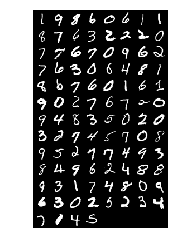

In [8]:
reconsPath = './gan_samples/real_images.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()


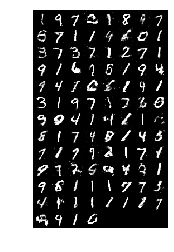

In [9]:
reconsPath = './gan_samples/fake_images-200.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()